In [1]:
# Import necessary libraries
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image
from time import sleep
import os
import numpy as np
from sklearn.metrics import classification_report

from amb_sdk.sdk import DarwinSdk
import datetime
ts = '{:%Y%m%d%H%M%S}'.format(datetime.datetime.now())

In [2]:
# Login
ds = DarwinSdk()
ds.set_url('https://amb-demo-api.sparkcognition.com/v1/')
status, msg = ds.auth_login_user('brandonwright@utexas.edu', 'wLXEQ8ffrB')

if not status:
    print(msg)
else:
    print('You are logged in!')

You are logged in!


In [3]:
# Formats the dataframe so that all columns are the same for each year's data
def get_formatted_dataframe(xls_file, year):
    df = pd.read_excel(xls_file)
    df = df[['DZRATING', 'DZCAMPUS','DPETALLC','DA0AT' + str(year) + 'R', 'DA0912DR' + str(year) + 'R','DAGC4X' + str(year) + 'R','DAGC5X' + str(year - 1) + 'R','DA0GR' + str(year) + 'N','DA0CT' + str(year) + 'R','DA0CC' + str(year) + 'R','DA0CSA' + str(year) + 'R','DA0CAA' + str(year) + 'R','DPSTTOSA','DPSTEXPA','DPFRAALLT','DPFRAALLK','DPFRASTAP','DZRVLOCP','DPFRAFEDP','DPFEAINST','DPFEAINSK','DISTSIZE','COMMTYPE', 'PROPWLTH', 'TAXRATE']]
    df = df.rename(index=str, columns = {"DZRATING":"rating", "DZCAMPUS":"num_schools", "DPETALLC":"num_students", "DA0AT" + str(year) + "R":"attendance_rate", "DA0912DR" + str(year) + "R":"dropout_rate", "DAGC4X" + str(year) + "R":"grad_rate_4_year", "DAGC5X" + str(year - 1) + "R":"grad_rate_5_year", "DA0GR" + str(year) + "N":"annual_grad_count", "DA0CT" + str(year) + "R":"college_admissions_per_tested", "DA0CC" + str(year) + "R":"college_admissions_at_crit", "DA0CSA" + str(year) + "R":"average_sat", "DA0CAA" + str(year) + "R":"average_act", "DPSTTOSA":"average_teacher_salary", "DPSTEXPA":"average_teacher_exp", "DPFRAALLT":"total_revenue", "DPFRAALLK":"total_revenue_per_pupil", "DPFRASTAP":"percent_revenue_from_state", "DZRVLOCP":"percent_revenue_from_local", "DPFRAFEDP":"percent_revenue_from_federal", "DPFEAINST":"instr_expenditures", "DPFEAINSK":"instr_expenditures_per_pupil", "DISTSIZE":"district_size", "COMMTYPE":"community_type", "PROPWLTH":"property_wealth", "TAXRATE":"tax_rate"})
    return df

In [4]:
# Combine different years' data to create testing and training datasets
test_df = get_formatted_dataframe('2016-2017.xls', 16)
train_df = get_formatted_dataframe('2015-2016.xls',15)
train_df = train_df.append(get_formatted_dataframe('2014-2015.xls',14))
train_df = train_df.append(get_formatted_dataframe('2013-2014.xls',13))
print('Test dataframe shape:', test_df.shape)
print('Train dataframe shape:', train_df.shape)

Test dataframe shape: (1203, 25)
Train dataframe shape: (3653, 25)


In [5]:
# Filter out unused classifications, strings in numerical columns, and NaN values
def clean_dataframe(df):
    df = df.loc[(df['rating'] == "Met Standard") | (df['rating'] == "Met Alternative Standard") |(df['rating'] == "Improvement Required")]
    features = list(df)[3:21]
    for feature in features:
        df = df.loc[(df[feature] != '.')]
    df = df.dropna()
    return df

In [6]:
# Manually cleaning the data
train_df = clean_dataframe(train_df)
test_df = clean_dataframe(test_df)
print('After cleaning:')
print('Test dataframe shape:', test_df.shape)
print('Train dataframe shape:', train_df.shape)

After cleaning:
Test dataframe shape: (908, 25)
Train dataframe shape: (2749, 25)


In [7]:
# Dealing with class imbalance
labels = list(train_df)[1:]

print("Before oversampling:")
print(train_df['rating'].value_counts())
print()

# Use SMOTE to upsample the minority classes
from imblearn.over_sampling import SMOTENC
ad = SMOTENC(categorical_features=[20, 21, 22, 23], random_state=123)
train_df_y = train_df['rating']
train_df_x = train_df.iloc[:,1:]
x_res, y_res = ad.fit_sample(train_df_x, train_df_y)

train_df = pd.DataFrame(data=x_res, columns=labels)
train_df['rating'] = y_res

print("After oversampling:")
print(train_df['rating'].value_counts())

Before oversampling:
Met Standard                2589
Improvement Required         107
Met Alternative Standard      53
Name: rating, dtype: int64

After oversampling:
Met Alternative Standard    2589
Met Standard                2589
Improvement Required        2589
Name: rating, dtype: int64


In [8]:
# Export dataframes to csv files
test_df.to_csv('test_data.csv')
train_df.to_csv('train_data.csv')

In [9]:
# Upload test and training datasets
TRAIN_DATASET = 'train_data.csv'
TEST_DATASET = 'test_data.csv'
train_df = pd.read_csv('train_data.csv')
test_df = pd.read_csv('test_data.csv')
status, message = ds.delete_dataset(TRAIN_DATASET)
status, dataset = ds.upload_dataset(TRAIN_DATASET)
if not status:
    print(dataset)
status, message = ds.delete_dataset(TEST_DATASET)
status, dataset = ds.upload_dataset(TEST_DATASET)
if not status:
    print(dataset)

In [10]:
# Clean the training data
target = "rating"
status, job_id = ds.clean_data(TRAIN_DATASET, target = target)
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-23T14:08:29.409563', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['train_data.csv'], 'artifact_names': ['f0e06fbba77543ed9aae4884fff24080'], 'model_name': None, 'job_error': None}
{'status': 'Complete', 'starttime': '2019-04-23T14:08:29.409563', 'endtime': '2019-04-23T14:08:33.712298', 'percent_complete': 100, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['train_data.csv'], 'artifact_names': ['f0e06fbba77543ed9aae4884fff24080'], 'model_name': None, 'job_error': ''}


In [11]:
# Create and train the model
model = target + "_model01" + ts
status, job_id = ds.create_model(dataset_names = TRAIN_DATASET, \
                                 model_name =  model, \
                                 max_train_time = '00:02')
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-23T14:08:45.8053', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['train_data.csv'], 'artifact_names': None, 'model_name': 'rating_model0120190423140816', 'job_error': None}
{'status': 'Running', 'starttime': '2019-04-23T14:08:45.8053', 'endtime': None, 'percent_complete': 8, 'job_type': 'TrainModel', 'loss': 0.5769777297973633, 'generations': 2, 'dataset_names': ['train_data.csv'], 'artifact_names': None, 'model_name': 'rating_model0120190423140816', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-23T14:08:45.8053', 'endtime': None, 'percent_complete': 20, 'job_type': 'TrainModel', 'loss': 0.6230087280273438, 'generations': 8, 'dataset_names': ['train_data.csv'], 'artifact_names': None, 'model_name': 'rating_model0120190423140816', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-23T14:08:45.8053', 'endtime': None, 'percent_complete': 20, 'job_typ

In [12]:
# Retrieve feature importance of built model
status, artifact = ds.analyze_model(model)
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])


{'status': 'Running', 'starttime': '2019-04-23T14:11:02.602851', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.6230087280273438, 'generations': 8, 'dataset_names': None, 'artifact_names': ['cdb041470dd044f2afdbd485d46f4925'], 'model_name': 'rating_model0120190423140816', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-23T14:11:02.602851', 'endtime': '2019-04-23T14:11:04.276786', 'percent_complete': 100, 'job_type': 'AnalyzeModel', 'loss': 0.6230087280273438, 'generations': 8, 'dataset_names': None, 'artifact_names': ['cdb041470dd044f2afdbd485d46f4925'], 'model_name': 'rating_model0120190423140816', 'job_error': ''}


In [13]:
# Print features in order of importance
feature_importance[:10]

Unnamed: 0                        0.393380
percent_revenue_from_local        0.108572
attendance_rate                   0.057002
grad_rate_5_year                  0.041164
percent_revenue_from_state        0.041159
average_sat                       0.040035
college_admissions_per_tested     0.036542
tax_rate = Non-taxing entities    0.030083
total_revenue                     0.027108
grad_rate_4_year                  0.026001
dtype: float64

In [14]:
# Run model on training set
status, artifact = ds.run_model(TRAIN_DATASET, model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

{'status': 'Complete', 'starttime': '2019-04-23T14:11:20.253756', 'endtime': '2019-04-23T14:11:21.304984', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.6230087280273438, 'generations': 8, 'dataset_names': ['train_data.csv'], 'artifact_names': ['6c584c2e112049de8283929b289dc38a'], 'model_name': 'rating_model0120190423140816', 'job_error': ''}


(True, 'Job completed')

In [15]:
# Get model's predicted values for training set
status, prediction = ds.download_artifact(artifact['artifact_name'])
prediction.head()

,prob_Improvement Required,prob_Met Alternative Standard,prob_Met Standard,rating
0,0.000706,1.324000e-07,0.999294,Met Standard
1,0.000070,1.185000e-07,0.999930,Met Standard
2,0.000800,1.012600e-06,0.999199,Met Standard
3,0.000195,4.753000e-06,0.999801,Met Standard
4,0.000421,6.194000e-07,0.999579,Met Standard


                          precision    recall  f1-score   support

    Improvement Required       0.99      0.98      0.99      2589
Met Alternative Standard       1.00      1.00      1.00      2589
            Met Standard       0.98      0.99      0.98      2589

               micro avg       0.99      0.99      0.99      7767
               macro avg       0.99      0.99      0.99      7767
            weighted avg       0.99      0.99      0.99      7767



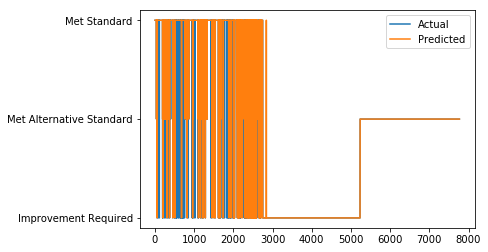

In [16]:
# Create plots comparing predictions with actual 
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(train_df[target] == q).values
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print(classification_report(train_df[target], prediction[target]))

In [17]:
# Clean the test data
status, job_id = ds.clean_data(TEST_DATASET, target = target, model_name = model)

if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-23T14:11:23.513273', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['test_data.csv'], 'artifact_names': ['55081990c67c4856b6c3766b25ae5a0a'], 'model_name': None, 'job_error': None}
{'status': 'Complete', 'starttime': '2019-04-23T14:11:23.513273', 'endtime': '2019-04-23T14:11:25.480953', 'percent_complete': 100, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['test_data.csv'], 'artifact_names': ['55081990c67c4856b6c3766b25ae5a0a'], 'model_name': None, 'job_error': ''}


In [18]:
# Run model on the test data
status, artifact = ds.run_model(TEST_DATASET, model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

{'status': 'Running', 'starttime': '2019-04-23T14:11:39.829553', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.6230087280273438, 'generations': 8, 'dataset_names': ['test_data.csv'], 'artifact_names': ['e6d6a5648c314622b44db6b8c6a53cfe'], 'model_name': 'rating_model0120190423140816', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-23T14:11:39.829553', 'endtime': '2019-04-23T14:11:41.183073', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.6230087280273438, 'generations': 8, 'dataset_names': ['test_data.csv'], 'artifact_names': ['e6d6a5648c314622b44db6b8c6a53cfe'], 'model_name': 'rating_model0120190423140816', 'job_error': ''}


(True, 'Job completed')

In [19]:
# Get model's predicted values for test set
status, prediction = ds.download_artifact(artifact['artifact_name'])
prediction.head()

,prob_Improvement Required,prob_Met Alternative Standard,prob_Met Standard,rating
0,1.115200e-06,4.700000e-09,0.999999,Met Standard
1,6.118000e-07,2.680000e-08,0.999999,Met Standard
2,1.062800e-06,5.800000e-09,0.999999,Met Standard
3,9.433300e-06,2.092000e-07,0.999990,Met Standard
4,6.117400e-06,2.437000e-07,0.999994,Met Standard


                          precision    recall  f1-score   support

    Improvement Required       0.00      0.00      0.00        19
Met Alternative Standard       0.78      0.78      0.78        18
            Met Standard       0.98      1.00      0.99       871

               micro avg       0.97      0.97      0.97       908
               macro avg       0.58      0.59      0.59       908
            weighted avg       0.95      0.97      0.96       908



/home/brandon/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


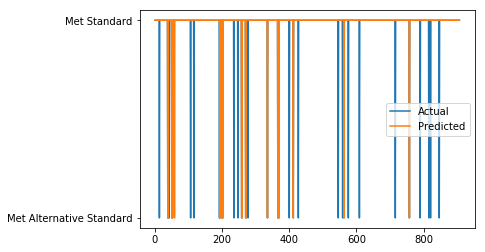

In [20]:
# Create plots comparing predictions with actual
df = pd.read_csv(TEST_DATASET)
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(df[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print(classification_report(df[target], prediction[target]))